# Introduction to seismic modelling

This notebook highlights the core of seismic modelling. 



In [1]:
# A few  utilities to plot 

import matplotlib.pyplot as plt
from matplotlib import cm


def plot_rec(rec, origin, spacing, dimensions, t0, tn):
    plt.figure()
    plt.imshow(rec[::-1,:], vmin=-1, vmax=1, cmap=cm.gray, aspect=2,
               extent=[origin[0], origin[0] + 1e-3*dimensions[0] * spacing[0],
               1e-3*tn, t0])
    plt.xlabel('X position (km)',  fontsize=20)
    plt.ylabel('Time (s)',  fontsize=20)
    plt.tick_params(labelsize=20)
    plt.show()
    
    
def plot_velocity(v, origin, spacing, dimensions):
    plt.figure()
    plt.imshow(np.transpose(v), animated=True, vmin=min(v.reshape(-1)), vmax=max(v.reshape(-1)), cmap=cm.jet, 
               extent=[origin[0], origin[0] + 1e-3 * (dimensions[0]-1) * spacing[0],
               origin[1] + 1e-3*(dimensions[1]-1) * spacing[1], origin[1]])
    plt.xlabel('X position (km)',  fontsize=20)
    plt.ylabel('Depth (km)',  fontsize=20)
    plt.tick_params(labelsize=20)
    plt.show()
    
# Import symbols 

from sympy import symbols

# Seismic modelling 

## The acoustic seismic wave equation
The acoustic wave equation for the square slowness m defined as $m=\frac{1}{c^2}$, where $c$ is the speed of sound in the given physical media, and a source q is given in 3D by :

\begin{cases} 
 &m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) =q  \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

with the zero initial conditons to guaranty unicity of the solution.
The boundary condtions are Dirichlet conditions :

\begin{equation}
 u(x,t)|_\Omega = 0
\end{equation}

where $\Omega$ is the surface of the boundary of the model.

# Measurement and source

In most of the case as seismic survey consit of two main components

- A source. This is source is localized a single physical location. In the case of land survey, it is usually a dynamite blowing up at a given location, or a vibroseis (a vibrating engine generating continuous  sounfd waves). For a marine survey, the source is an air gun sending a bubble of compressed air in the water that will expand and generate a seismic wave.
- A set of measurements called a *Shot Record*. This measurement are recoded at multiple location, and usually at the surface.


#Modelling workflow

In order to model a numerical equivalent to a seismic survey, one needs to solve the wave equation and implement source and receiver interpolation to inject the  source and record the seismic wave at sparse locations.

# FInite domains

The last piece of the puzzle is the computational limitation. In the field, the seismic wave propagate in every directions to "infite" distance. However, solving the wave equation in a mathematically infinite domain is not feasible. In order to compensate, Absorbing Boundary Conditions (ABC) or  Perfctly Matched Layers (PML) are required to mimic an infinite domain. These two method allow to approximate an infinte media by damping and absorbing the waves at the limit of the domain to avoid reflections.

The simplest of these methods is the absorbing damping mask. The core idea is to extend the physical domain and to add a Sponge mask in this extension that will absorb the incident waves. The acoustic wave equation with this damping mask can be rewritten as:

\begin{cases} 
 &m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) + \eta \frac{d u(x,t)}{dt}=q  \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

where $\eta$ is the damping mask equal to $0$ inside the physical domain and increasing inside the sponge layer. Multpile choice of profile can be chosen for $\eta$ from linear to exponential.

# Seismic modelling with devito

We desribe here a step by step stup of seismic modelling with devito in a simple 2D case.


## Define the physical problem

The first step is to define the physical model:

- What are the physical dimension of interest
- What is the velocity profile of this pysical domain

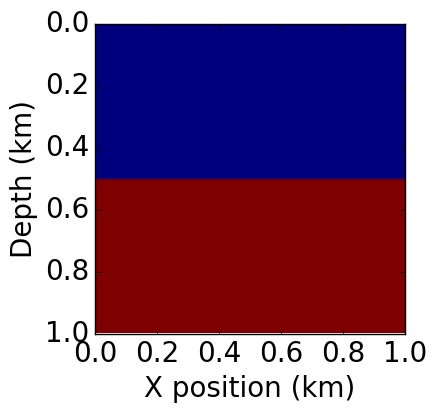

In [2]:
# Let's import a few required component

# All Devito arrays are numpy arrays that are compatible with the generated C code memory layout
# and with most python tools

import numpy as np

# We import now the Model abstraction for seismic modeling
from examples.seismic import Model

# Define a physical size
n = (101, 101)  # Number of grid point (nx, nz)
d = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary tto define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s

v = np.ones(n, dtype=np.float32) +.5
v[:, 51:] = 2.5

plot_velocity(v, origin, d, n)

# With the velocity and model size defined, we can create the seismic model that
# encapsulate this properties. We also define the size of the absorbing layer as 10 grid points

model = Model(origin, d, n, v, nbpml=10)

# Acquisition geometry

Let's define a source with it's location and a receiver array.
The source time signature we use is a Ricker wavelet defined as

\begin{equation}
  q(t) = (1-2\pi^2 f_0^2 (t - \frac{1}{f_0})^2 )e^{- \pi^2 f_0^2 (t - \frac{1}{f_0})}
\end{equation}

The source is positioned at a 20m depth and at the middle of the $x$ axis ($x_{src}=500m$) while the receivers are positioned at the same depth every $10m$ along the x axis.

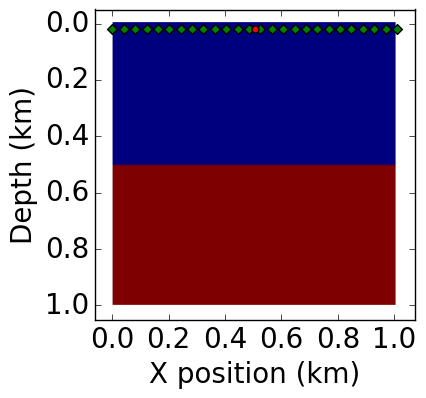

In [3]:
# Import require devito class

from examples.seismic import PointSource, Receiver

# First we need to define the time duration of the simulation and the frequency of the source

t0 = 0.  # Simulation starts a t=0
tn = 1000. # Simulation last 1 second (1000 ms)
f0 = 0.010  # SOurce peak frequency is 10Hz (0.010 kHz)

dt = model.critical_dt  # Computational time step. This value is obtained from
# the maximum velocity and the grid size and is defined with the CFL condition. This is the 
# numerical condition to ensure the discrete model is stable. We will define it properly
# later on but is required here.
nt = int(1+(tn-t0)/dt)  # Discrete time axis length
# Source initalization


def Ricker(t, f0):
    r = (np.pi * f0 * (t - 1./f0))
    return (1-2.*r**2)*np.exp(-r**2)

time_series = np.zeros((nt, 1))
time_series[:, 0] = Ricker(np.linspace(t0, tn, nt), f0)

# We only have a single source
location = np.zeros((1, 2))
location[0, 0] = origin[0] + n[0] * d[0] * 0.5
location[0, 1] = 20.

src = PointSource(name='src', data=time_series, coordinates=location)


# Receiver initialization. This one does not contain any data as it will be computed during
# the simulation.

receiver_coords = np.zeros((101, 2))
receiver_coords[:, 0] = np.linspace(0, origin[0] +
                                    n[0] * d[0], num=101)
receiver_coords[:, 1] = location[0, 1]
rec = Receiver(name='rec', ntime=nt, coordinates=receiver_coords)

# Visualization. We show the acquisition geometry on the next figure where the red dot is the
# source position and the green dots are the receivers locations

plt.figure()
plt.imshow(np.transpose(v), vmin=min(v.reshape(-1)), vmax=max(v.reshape(-1)), cmap=cm.jet, 
           extent=[origin[0], origin[0] + 1e-3 * (n[0]-1) * d[0],
           origin[1] + 1e-3*(n[1]-1) * d[1], origin[1]])
plt.xlabel('X position (km)',  fontsize=20)
plt.ylabel('Depth (km)',  fontsize=20)
plt.tick_params(labelsize=20)
plt.scatter(1e-3*receiver_coords[::4, 0], 1e-3*receiver_coords[::4, 1], s=25, c='green', marker='D')
plt.scatter(1e-3*location[0, 0], 1e-3*location[0, 1], s=25, c='red', marker='o')
plt.show()

## Seting up the PDE

In [4]:
# Let's import a few required component

# In order to represent the wavefield u, and the squre slownees we need symbolic object 
# corresponding to time-space-varying field (u, TimeData) and 
# space-varying field (m, DenseData)
from devito.interfaces import TimeData

# Deine the wavefield with the size of the model and the time dimension

u = TimeData(name="u", shape=model.shape_domain, time_dim=nt, time_order=2, space_order=2)

# We can now write the pde

pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then reqrite the pde as 
# a time marching updating equation known as a stencil using sympy functions

from sympy import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward)[0])

# Finally we define the source injection and receiver read function to generate the corresponding code

src_term = src.inject(field=u, offset=model.nbpml, expr=src * dt * dt / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u, offset=model.nbpml)

# Devito operator and solve

In [5]:
# With all the necessary obkjects created we can create the Devito operator that will generate the
# C code at runtime
s, h = symbols('s h')
from devito.operator import Operator
op = Operator([stencil] + src_term + rec_term, subs={s: dt, h: d[0]})

# The creation of the operators prints the optimizations made on the stencil to
# optimize the computation

DSE: extract_time_invariants [flops: 22, elapsed: 0.00] >>
     eliminate_inter_stencil_redundancies [flops: 22, elapsed: 0.00] >>
     eliminate_intra_stencil_redundancies [flops: 22, elapsed: 0.00] >>
     factorize [flops: 19, elapsed: 0.01] >>
     finalize [flops: 19, elapsed: 0.00]
     [Total elapsed: 0.02 s]


DLE: analyze [elapsed: 0.01] >>
     avoid_denormals [elapsed: 0.00] >>
     loop_fission [elapsed: 0.00] >>
     create_elemental_functions [elapsed: 0.01] >>
     loop_blocking [elapsed: 0.09] >>
     simdize [elapsed: 0.01] >>
     ompize [elapsed: 0.00]
     [Total elapsed: 0.12 s]


In [6]:
op.apply()

FAILED compiler invocation: gcc-5 -O3 -g -march=native -fPIC -Wall -std=c99 -shared -fopenmp /var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-501/fa7079973f54bae1960b954fd6990be478e1b401.c -o /var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-501/fa7079973f54bae1960b954fd6990be478e1b401.dylib


CompileError: module compilation failed

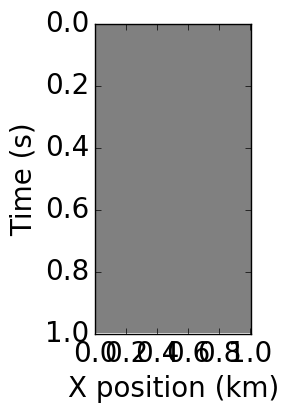

In [78]:
plot_rec(rec.data, origin, d, n, t0, tn)